In [1]:
%%time
import manager_dataset as MD
import question_processing as QP
import information_retrieval as IR
import named_entity_recognition as NER
import answer_processing as AP
from gensim.models import KeyedVectors
from util import util

C:\Users\55519\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Wall time: 7.6 s


In [2]:
import warnings
warnings.filterwarnings('ignore')

### Settings

Questions recive all the questions treated

In [3]:
questions = MD.questions(treated=True)
incosiderate_classes = ['X', 'MANNER', 'OBJECT', 'OTHER', 'DEFINITION']
questions = QP.remove_incosiderate_classes(questions, incosiderate_classes)  # Question with incosiderate class is removed

The questions that has an answer will be used for test while another questions will be used for train.

In [4]:
train_questions, test_questions = MD.split_questions(questions)

## Question Processing

### Question Classification

Or Load the Word2Vec model

In [ ]:
%%time
w2v_patch = 'data/word_embedding/cbow_s300.txt'
#w2v_patch = 'data/word_embedding/cbow_s50.txt'  # Fast test
w2v = KeyedVectors.load_word2vec_format(w2v_patch, unicode_errors="ignore")
model_w2v = {w: vec for w, vec in zip(w2v.index2word, w2v.syn0)}

And Train a SVM model

In [ ]:
%%time
qc_X_train, qc_y_train = QP.separete_questions(train_questions)

classifier = QP.svm_classifier()
vectorizer = QP.HybridVectorizer(model_w2v)
#vectorizer = QP.MeanEmbeddingVectorizer(model_w2v)
#vectorizer = QP.TfidfHybridVectorizer(model_w2v)
#vectorizer = QP.SequenceHybridVectorizer(model_w2v)
#vectorizer = QP.count_vectorizer(model_w2v)
#vectorizer = QP.tfidf_vectorizer(model_w2v)
model = QP.train_model(qc_X_train, qc_y_train, classifier, vectorizer)

Or Loading the the trained SVM model

In [5]:
%%time
import dill
model = dill.load(open(QP.answer_type_file, 'rb'))

Wall time: 3.61 s


Answer type is predicted for all questions

In [6]:
%%time
questions = QP.predict_answer_type(model, test_questions)

Wall time: 298 ms


#### Testing

In [7]:
qc_X_test, qc_y_test = QP.separete_questions(test_questions)
print('Size train:',len(train_questions),'  Size test:',len(qc_y_test))

Size train: 1705   Size test: 644


Accuracy: 0.9114906832298136
F1 Score: 0.904503905742397


<IPython.core.display.Javascript object>


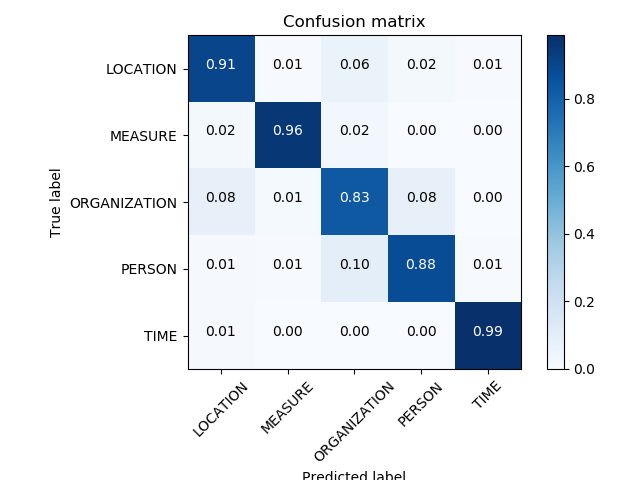

In [8]:
%matplotlib notebook
confusion_matrix = QP.testing(model, qc_X_test, qc_y_test)
QP.plot_confusion_matrix(confusion_matrix, ['LOCATION', 'MEASURE', 'ORGANIZATION', 'PERSON', 'TIME'], normalize=True)

### Query Formulation

All test questions will recive the query for IR module. 

In [9]:
%%time
test_questions = QP.queryFormulation(test_questions)

Wall time: 3.06 s


## Information Retrieval

### Document Retrieval

In [10]:
import information_retrieval as IR
ir = IR.InformationRetrieval()

Start the IR module. If the documents was not indexed then they will be.
When reset is True, all indexed documents is removed and indexed again.

In [11]:
%%time
ir.start(reset=False)

Wall time: 79.2 ms


In [12]:
%%time
test_questions = ir.retrievalDocuments(test_questions)

Retrieval Documents [ . . . . . . . . . . ]
Wall time: 13.8 s


#### Testing

In [14]:
IR.test_ir_system(test_questions)

Precision: 0.07749606918238994
Recall: 0.5910770440251573
F-Score: 0.13167466743701484


### Named Entity Recognition

Train model

In [1]:
%%time
import named_entity_recognition as NER
model_ner = NER.train()

Wall time: 26.2 s


Or load model

In [15]:
%%time
import named_entity_recognition as NER
import dill
model_ner = dill.load(open(NER.file_ner, 'rb'))

Wall time: 24.6 ms


#### Testing

In [16]:
NER.test_approach()

Sentences: 3319 Train: 2655 Test: 664
F1-Score:0.643
                 precision    recall  f1-score   support

        VALOR-B      0.783     0.867     0.823        83
        VALOR-I      0.833     0.793     0.813        82
      OBJECTO-B      0.000     0.000     0.000         0
         OBRA-B      0.600     0.290     0.391        62
         OBRA-I      0.431     0.398     0.414       118
   ABSTRACCAO-B      0.754     0.474     0.582        97
   ABSTRACCAO-I      0.566     0.395     0.465        76
ACONTECIMENTO-B      0.250     0.200     0.222        15
ACONTECIMENTO-I      0.083     0.176     0.113        34
        TEMPO-B      0.818     0.791     0.804        91
        TEMPO-I      1.000     0.852     0.920        61
       PESSOA-B      0.665     0.680     0.672       178
       PESSOA-I      0.613     0.695     0.651       164
        LOCAL-B      0.739     0.814     0.775       226
        LOCAL-I      0.592     0.562     0.577       137
        COISA-B      0.636     0.3

In [17]:
NER.predict(model_ner, u'No Brasil, mora o aluno Eduardo Cortes. Ele estuda na UFRGS em Porto Alegre')[0]

['O',
 'LOCAL-B',
 'O',
 'O',
 'O',
 'PESSOA-B',
 'PESSOA-I',
 'O',
 'O',
 'O',
 'ORGANIZACAO-B',
 'O',
 'LOCAL-B',
 'LOCAL-I']

### Passage Retrieval

In [18]:
%%time
test_questions = IR.retrievalPassagesQuestions(test_questions, model_ner, ir)

Passages Retrieval [ . . . . . . . . . . ]
Wall time: 1min 46s


## Answer Processing

### Answer Extraction

In [19]:
%%time
test_questions = AP.answer_candidates(test_questions, ir, model_ner)

Answer Candidates [ . . . . . . . . . . ]
Wall time: 4.19 s


### Final Answer Selection

In [20]:
%%time
test_questions = AP.finals_answer(test_questions)

Final Answer[ . . . . . . . . . . ]
Wall time: 311 ms


In [112]:
print(test_questions[0]['question'])
print(test_questions[0]['query'])
print(test_questions[0]['answers'])
#for ac in test_questions[1]['answer_candidates']:
#    print(float(("%0.1f"%ac['doc_rank'])), float(("%0.1f"%ac['votes'])), float(("%0.1f"%ac['score'])))


Em que cidade se encontra a prisão de San Vittore?
{'fl': 'id', 'rows': '10', 'q': 'cidade encontra prisão san vittore', 'defType': 'edismax', 'qf': 'text', 'pf': 'text', 'ps': '5', 'pf2': 'text', 'ps2': '10', 'pf3': 'text', 'ps3': '20', 'wt': 'json', 'indent': 'false'}
[{'answer': '\nMilão\n', 'n': '2', 'doc': 'PUBLICO-19940724-039'}]


In [114]:
import pprint
pp = pprint.PrettyPrinter()
pp.pprint(test_questions[0])

{'answer_candidates': [{'doc_rank': 0.0,
                        'full_answer': 'Milão',
                        'passage_text': 'Milão Tangentópolis, a devoradora Da '
                                        'nossa enviada Alexandra Prado Coelho, '
                                        'em Milão A cidade mais rica e mais '
                                        'cara da Itália transformou-se no '
                                        'símbolo da corrupção: Milão -- '
                                        'Tangentópolis.',
                        'score': 0.44545454545454544,
                        'votes': 0.6363636363636364,
                        'words': [('Milão', 11)]},
                       {'doc_rank': 0.0,
                        'full_answer': 'Itália',
                        'passage_text': 'Milão Tangentópolis, a devoradora Da '
                                        'nossa enviada Alexandra Prado Coelho, '
                                        'em Milão A cid

                                        'para transformar a Itália numa '
                                        'federação, é ainda Bernard Poche quem '
                                        'escreve: O facto de que existe uma '
                                        "`identidade', ou mais exactamente um "
                                        'sentimento de pertença específica às '
                                        "diversas `grandes regiões' de Itália "
                                        'é uma evidência para quem conhece bem '
                                        'o país.',
                        'score': 0.44545454545454544,
                        'votes': 0.6363636363636364,
                        'words': [('Itália', 9)]},
                       {'doc_rank': 0.0,
                        'full_answer': 'Itália',
                        'passage_text': 'Quanto às polémicas propostas da Liga '
                                        'para transformar a Itália

                                        'corrupção investigado pela Operação '
                                        'Mãos Limpas.',
                        'score': -0.13636363636363635,
                        'votes': 0.09090909090909091,
                        'words': [('Milão', 16)]},
                       {'doc_rank': 0.2222222222222222,
                        'full_answer': 'Catania Sicília',
                        'passage_text': 'Em Catania (Sicília), o candidato do '
                                        'Movimento Social Italiano (MSI, '
                                        'neofascista, que domingo mudou seu '
                                        'nome para Aliança Nacional) ao '
                                        'governo provincial, Nello Musumeci, '
                                        'foi o primeiro colocado no primeiro '
                                        'turno das eleições, com 24,4% dos '
                                        'votos.',

                                        'maiores competições distam milhas '
                                        'marítimas das de outrora, quando, por '
                                        'exemplo, o finlandês Pekka '
                                        'Paeivaerinta foi campeão do mundo.',
                        'score': -0.39999999999999997,
                        'votes': 0.0,
                        'words': [('Leste', 13), ('Rússia', 14)]},
                       {'doc_rank': 0.4444444444444444,
                        'full_answer': 'Norte',
                        'passage_text': 'O circuito britânico é muito '
                                        'doméstico; no Centro da Europa '
                                        '(Alemanha, Polónia), no Leste '
                                        '(Rússia) e no Norte (todos os países '
                                        'nórdicos) o fenómeno é cada vez mais '
                                        'marginal e

                                        'na derradeira prova -- os Mundiais '
                                        '--, que valia a dobrar.',
                        'score': -0.39999999999999997,
                        'votes': 0.0,
                        'words': [('Ismael', 17)]},
                       {'doc_rank': 0.4444444444444444,
                        'full_answer': 'Europeus',
                        'passage_text': 'Domingos Castro (Sporting), segundo '
                                        'nos Europeus, teve também uma época '
                                        'de grande qualidade.',
                        'score': -0.3363636363636363,
                        'votes': 0.09090909090909091,
                        'words': [('Europeus', 5)]},
                       {'doc_rank': 0.4444444444444444,
                        'full_answer': 'Nacionais',
                        'passage_text': 'Só que encontrou Paulo Guerra pela '
                                  

                       {'doc_rank': 0.5555555555555556,
                        'full_answer': 'Rio Maior',
                        'passage_text': 'Atletismo Fim-de-semana carregado '
                                        'Albertina Dias (Maratona da Maia) e '
                                        'Susana Feitor (Natação de Rio Maior) '
                                        'são os principais atletas portugueses '
                                        'a actuar no estrangeiro em mais um '
                                        'fim-de-semana de agenda carregada.',
                        'score': -0.5,
                        'votes': 0.0,
                        'words': [('Rio', 13), ('Maior', 14)]},
                       {'doc_rank': 0.5555555555555556,
                        'full_answer': 'Espanha',
                        'passage_text': 'Susana vai participar amanhã nos '
                                        'Campeonatos de Espanha de marcha, que '
               

                                        'estava já na sua posse.',
                        'score': -0.6,
                        'votes': 0.0,
                        'words': [('Atlanta', 26)]},
                       {'doc_rank': 0.6666666666666666,
                        'full_answer': 'Geórgia',
                        'passage_text': 'Atrás dela, excelente registo ainda '
                                        'para a noruguesa Hanne Haugland, com '
                                        '1,96m. Na primeira jornada do '
                                        'campeonato norte-americano de pista '
                                        'coberta, que está a decorrer em '
                                        'Atlanta, na Geórgia, o maior destaque '
                                        'vai para o recorde nacional feminino '
                                        'dos 200m, da autoria da campeã '
                                        'olímpica Gwen Torrence, com 22,84s,

                          'Justiça e as celas de San Vittore, Milão é também a '
                          'cidade de Craxi, da Liga Norte e de Silvio '
                          'Berlusconi.',
               'sequence': 2},
              {'doc_id': 'PUBLICO-19940328-046',
               'doc_rank': 1,
               'entitys': ['O',
                           'O',
                           'O',
                           'O',
                           'LOCAL-B',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'LOCAL-B',
                           'O',
                           'O',
                           'O',
                           'ORGANIZACAO-B',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',


                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'LOCAL-B'],
               'passage': 'Bossi foi um instrumento útil para derrubar o velho '
                          'regime, mas hoje muitos milaneses viram-lhe as '
                          'costas, exactamente como as viram a Craxi.',
               'sequence': 26},
              {'doc_id': 'PU

                           'O',
                           'O',
                           'O',
                           'O',
                           'PESSOA-B',
                           'PESSOA-I',
                           'PESSOA-I',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O'],
               'passage': 'Depois de Berlusconi ter recuado, o '
                          'procurador-geral de Mi

                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'LOCAL-B',
                           'LOCAL-I',
                           'LOCAL-I',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'ABSTRACCAO-B',
                           'ABSTRACCAO-I',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O'],
               'passage': 'Segundo a France Presse, a frente conservadora, '
                          'batizada como Pólo da Liberdade, conta com '
                          'numerosos ex-in

               'passage': 'O marroquino Salah Hissou, terceiro em Durham, '
                          'merece ser considerado, a par de Paulo Guerra, como '
                          'a revelação do ano.',
               'sequence': 29},
              {'doc_id': 'PUBLICO-19950417-013',
               'doc_rank': 5,
               'entitys': ['O',
                           'O',
                           'LOCAL-B',
                           'O',
                           'O',
                           'O',
                           'PESSOA-B',
                           'PESSOA-I',
                           'PESSOA-I',
                           'PESSOA-I',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O'],
               'passage': 'Guerra e Albertina A nível português, Paulo Guerra '
                        

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,
               'sequence': 14},
              {'doc_id': 'PUBLICO-19950305-013',
               'doc_rank': 9,
               'entitys': ['O',
                           'O',
                           'O',
                           'LOCAL-B',
                           'LOCAL-I',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O',
                           'O'],
               'passage': 'Sotomayor perde em Berlim Grande destaque das '
                          'reuniões de pista coberta de ontem foi um facto '
                          'raro no salto em altura

#### Testing

Check if the answer_candidates have the right answer

In [21]:
AP.test_answer_candidates(test_questions)

644 / 398
Result: 61.801 %

Correct answer type:
587 / 373
Result: 63.543 %


## Final Evaluate

In [116]:
total = len(test_questions)
right = 0

cc_total = 0  # Total of question with correct candidates
cc_right = 0

for question in test_questions:
    aux = False
    if question['correct_answers_candidates']:
        aux = True
        cc_total += 1
    question['correct_final_answer'] = False
    for answer in question['answers']:
        if answer['answer'] is not None:
            a1 = answer['answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').strip()
            a2 = question['final_answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').strip()
            if a1 in a2 or a2 in a1:
                question['correct_final_answer'] = True
                right += 1
                if aux:
                    cc_right += 1
                break
print(str(total) + ' / ' + str(right))
print('Accuracy: '+ '%.3f' % ((right/total)*100)+' %')
print('\nCorrect answer candidates:\n' + str(cc_total) + ' / ' + str(cc_right))
print('Accuracy: '+ '%.3f' % ((cc_right/cc_total)*100)+' %')

644 / 120
Accuracy: 18.634 %

Correct answer candidates:
403 / 119
Accuracy: 29.529 %


Question Analysis

In [ ]:
print('Q = Question\nSA = System Answer\nCA = Correct Answer(s)')


print('\n##### Correct Answers #####\n')
for i in range(len(test_questions)):
    if test_questions[i]['correct_final_answer']:
        print('Index: ' + str(i))
        print('Q: ' + test_questions[i]['question'])
        print('SA: ' + test_questions[i]['final_answer'])
        print('CA: ', end='')
        for answer in test_questions[i]['answers']:
            if answer['answer'] is not None:
                print(answer['answer'].strip(), end=' | ')
        print('\n')


    


In [117]:
print('\n##### Wrong Answers #####\n')
for i in range(len(test_questions)):
    if not test_questions[i]['correct_final_answer']:
        print('Index: ' + str(i))
        print('Q: ' + test_questions[i]['question'])
        print('SA: ' + test_questions[i]['final_answer'])
        print('CA: ', end='')
        for answer in test_questions[i]['answers']:
            if answer['answer'] is not None:
                print(answer['answer'].strip(), end=' | ')
        print('\n')



##### Wrong Answers #####

Index: 0
Q: Em que cidade se encontra a prisão de San Vittore?
SA: Itália
CA: Milão | 

Index: 1
Q: Onde era o campo de concentração de Auschwitz?
SA: Alemanha
CA: Sul da Polónia | Polónia | Sudoeste da Polónia ocupada | 

Index: 4
Q: Quem foi o primeiro presidente dos Estados Unidos?
SA: Bill Clinton
CA: George Washington | 

Index: 5
Q: Com quem se casou Michael Jackson?
SA: Elvis Presley
CA: Lisa Marie Presley | 

Index: 7
Q: Quantos desempregados há na Europa?
SA: 13 por cento
CA: 23 milhões | 

Index: 8
Q: Quantas religiões monoteístas há no mundo?
SA: 22
CA: três | 

Index: 9
Q: Nomeie uma pessoa acusada de pedofilia.
SA: Vaticano
CA: Brendan Smyth | Hans Hermann Groer | 

Index: 10
Q: Quem escreveu Ulisses?
SA: Llosa
CA: James Joyce | 

Index: 11
Q: Onde se situa o CERN?
SA: França
CA: Genebra | 

Index: 12
Q: Em que dia calha o solstício de verão?
SA: século XX
CA: aproximadamente a 21 de Junho | 

Index: 13
Q: Onde fica o Museu do Hermitage?
SA: Por

CA: Chenuda III | Parthenios III | 

Index: 240
Q: Quem é o prefeito de Lisboa?
SA: Lula
CA: Jorge Sampaio | 

Index: 241
Q: Quem é o presidente da Macedónia?
SA: Atenas
CA: Kiro Gligorov | Kiro Gligorov | 

Index: 243
Q: Quem é o único atleta português nos Jogos Olímpicos de Lillehammer?
SA: Tonya Harding
CA: Georges Mendes | 

Index: 244
Q: Quem dirigiu o Congresso Nacional Africano de 1917 a 1924?
SA: Nelson Mandela
CA: Sefako Mapogo Makgatho | 

Index: 245
Q: Quem foi ministro da Justiça de Itália entre 1945 e 1946?
SA: Woller
CA: Palmiro Toglatti | 

Index: 246
Q: Quem foi primeiro-ministro de França durante o regime de Vichy?
SA: Paul Touvier
CA: Pierre Laval | 

Index: 247
Q: Quem teve o sobrenome Eidelshtein até aos 18 anos?
SA: Sônia
CA: Vladimir Jirinovski | 

Index: 251
Q: Quando foi José Meister mordido por um cão?
SA: 1882
CA: Junho de 1885 | 

Index: 253
Q: Quando foi descoberto o buraco de ozono?
SA: 1987
CA: 1986 | 

Index: 254
Q: Quando foi registado o último caso de r

Index: 456
Q: Quantas estações tem agora?
SA: 25
CA: 44 | 

Index: 457
Q: A que altitude está Miguel Pereira?
SA: entre 1870 e 1920
CA: 618 metros | 

Index: 458
Q: Em que instituição estudou?
SA: Associação de Utentes
CA: Faculdade do Largo São Francisco | 

Index: 459
Q: Quantos municípios tem o distrito do Porto?
SA: 12 milhões de contos
CA: 18 | 

Index: 461
Q: Qual o seu período de gestação de ocapi?
SA: 22 milhões
CA: 421 a 457 dias | 

Index: 462
Q: Qual o seu peso?
SA: 10
CA: varia entre 200 e 250 kg | 

Index: 463
Q: Que concelho fica a leste de Oeiras?
SA: Portugal
CA: Lisboa | 

Index: 464
Q: Que cidades realizaram Jogos Olímpicos antes de 1900?
SA: Atlanta
CA: Atenas | 

Index: 465
Q: Diga um recipiente da Grande Cruz do Mérito.
SA: Mondrian
CA: James Baker | 

Index: 466
Q: Quando começa o outono no hemisfério sul?
SA: Setembro
CA: 22 de março | 

Index: 467
Q: Onde é que ele nasceu?
SA: Brasil
CA: Cedofeita, no Porto | 

Index: 468
Q: Quantos centímetros há num pé?
SA: 3 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




SA: N/A
CA: Svetlana Savitskaya | 

Index: 604
Q: Quantos refugiados haitianos estão na base de Guantanamo?
SA: 14 mil
CA: 16 mil | 

Index: 605
Q: Quando foi fundado o Vasco da Gama?
SA: 11 de Abril
CA: 21 de agosto de 1898 | 

Index: 606
Q: Por quem foi fundado?
SA: Harvey Keitel
CA: um grupo de remadores | 

Index: 607
Q: Quando nasceu Vasco da Gama?
SA: 11 de Abril
CA: 1469 | 

Index: 608
Q: Onde é que ele morreu?
SA: São Paulo
CA: Cochim | 

Index: 610
Q: Em que ano é que Halle Berry venceu o Óscar?
SA: 1993
CA: 2003 | 

Index: 611
Q: Por que estados corre o Havel?
SA: Praga
CA: Brandemburgo, Berlim e Saxônia-Anhalt | 

Index: 612
Q: Diga um escritor irlandês.
SA: Paddy Clarke
CA: James Joyce | 

Index: 613
Q: Onde é que ele nasceu?
SA: Brasil
CA: Merrill, Oregon | 

Index: 614
Q: Quem eram os pais dele?
SA: Daniel Sampaio
CA: William Barks e sua esposa Arminta Johnson | 

Index: 615
Q: Quem realizou Os Pássaros?
SA: Michael Crichton
CA: Alfred Hitchcock | 

Index: 616
Q: Quantos

In [ ]:
for c in test_questions[0]['answer_candidates']:
    print(c['score'], c['votes'])

In [ ]:
sorted(test_questions[0]['answer_candidates'], key=lambda k: k['score'])[-1]

## Util

### Detailed Question Analysis

In [ ]:
question = {
    'question': u'Onde era o campo de concentração de Auschwitz?',
    'class': 'LOCATION'
}

question = test_questions[5]

print('Question: ' + question['question'])
print('Class: ' + question['class'])

# Question Classification
QP.predict_answer_type(model, [question])
print('Answer Type: ' + question['predict_class'])

# Query Formulation
QP.queryFormulation([question])
print('Query: ' + question['query']['q'])

# Document Retrieval
ir.retrievalDocuments([question])
print('Number of retrieval documents: ' + str(len(question['retrieval'])))

# Passages Retrieval
IR.retrievalPassagesQuestions([question], model_ner, ir)

# Answers Candidates
AP.answer_candidates([question], QP, ir, NER, model_ner)
print('Number of answer candidates: ' + str(len(question['answer_candidates'])))

# Final Answer
AP.finals_answer([question])
print('Answer: ' + question['final_answer'])

if 'answers' in question:
    print('Correct Answers: ', end='')
    for answer in question['answers']:
        if answer['answer'] is not None:
            print(answer['answer'].strip(), end=' | ')

Show documents id

In [ ]:
print('Retrieval Documents ID: ', end='')
for doc_id in question['retrieval']:
    print(doc_id, end=', ')

if 'answers' in question:
    print('\n\nRelevants Documents ID: ', end='')
    for answer in question['answers']:
        if answer['doc'] is not None and len(answer['doc']) > 0:
            print(answer['doc'], end=', ')

Show documents texts

In [ ]:
for doc_id in question['retrieval']:
    print('\n'+doc_id+'\n'+ir.documentText(doc_id))

In [ ]:
doc_id = 'PUBLICO-19940929-035'
print('\n'+doc_id+'\n'+ir.documentText(doc_id))

Show answers candidates

In [ ]:
for ac in question['answer_candidates']:
    print(ac['full_answer'])

Show most vote answer candidates

In [ ]:
import operator
votes = {}
for candidate in question['answer_candidates']:
    if candidate['full_answer'].lower() not in question['question'].lower():
        if candidate['full_answer'] not in votes:
            votes[candidate['full_answer']] = candidate['score']
[(k, votes[k]) for k in sorted(votes, key=votes.get, reverse=True)]

In [ ]:
for x in sorted(question['answer_candidates'], key=lambda k: k['score'])[::-1]:
    print(float(("%0.2f"%x['doc_rank'])), float(("%0.2f"%x['votes'])), float(("%0.2f"%x['score'])))  

In [ ]:
NER.predict(model_ner, u'Michael Jackson casou-se com a filha de Elvis Presley')[0]

### Others

In [ ]:
ir.stop()

In [37]:
import importlib
importlib.reload(NER)
#raise IpyExit

<module 'named_entity_recognition' from 'C:\\Users\\55519\\UFRGS\\QA\\qa-chave\\named_entity_recognition.py'>